In this notebook, we will come up with a model that will predict credit card defaults in September 2005 in Taiwan

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Exploratory Data Analysis

Providing a description of each feature:
    
ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
#splitting features and labels
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

Looking at the distribution of labels we were given:

0    23364
1     6636
Name: default.payment.next.month, dtype: int64


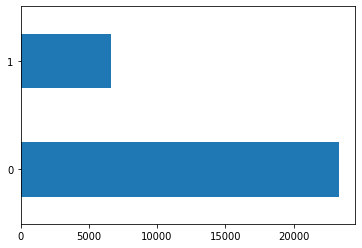

In [29]:
df['default.payment.next.month'].value_counts().plot(kind = "barh")
print(df['default.payment.next.month'].value_counts())

Examining the correlation heatmap, we can see that features are relatively uncorrelated except for bill_amt* and pay_* 

Regression algorithms seem appropriate

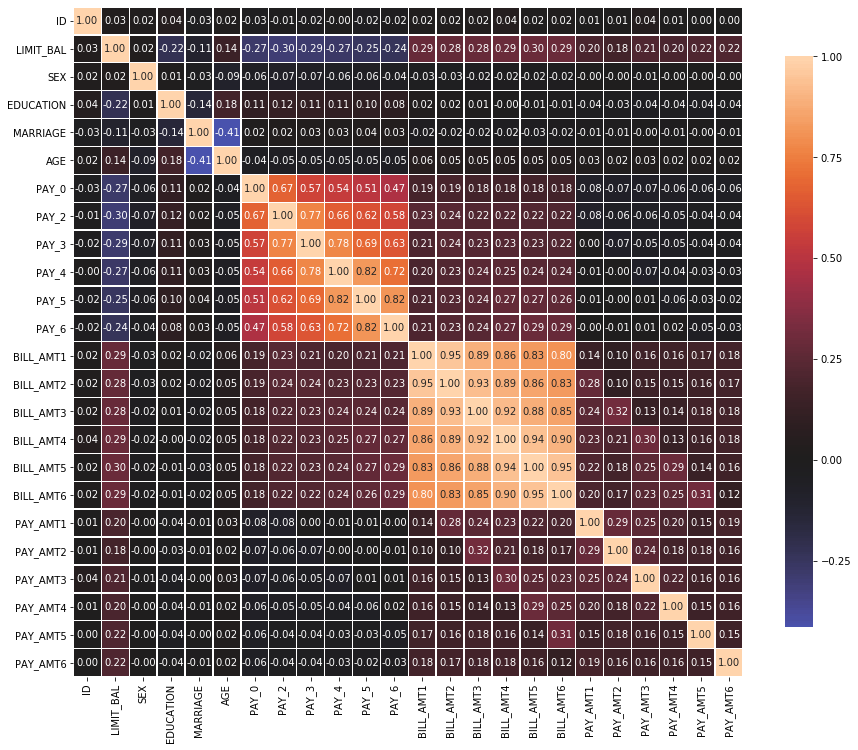

In [4]:
correlations = X.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

### Examining the distribution of variables
Specifically look at bill and pay

In [12]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

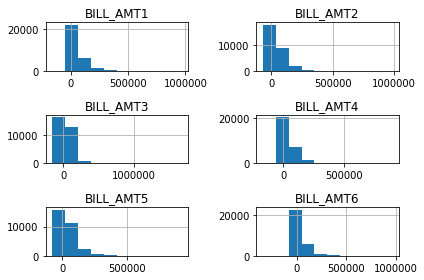

In [19]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 3, 2, 10)

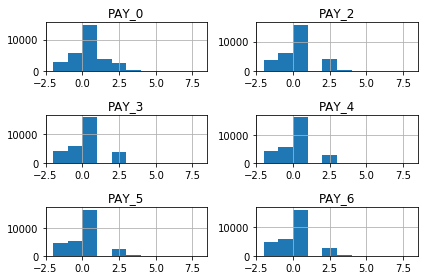

In [22]:
pays = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(pays, pays.columns, 3, 2, 10)

### Look at categorical variables for sparsity

Specifically looking at marriage and education

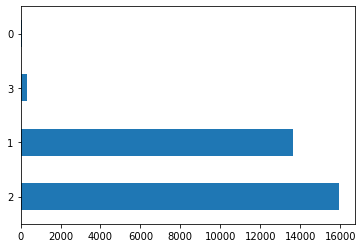

In [5]:
df.MARRIAGE.value_counts().plot(kind = "barh")

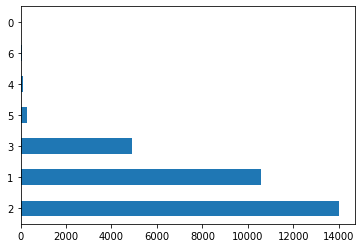

In [6]:
df.EDUCATION.value_counts().plot(kind = "barh")

Preliminary data cleaning:

To deal with the correlation issue, just drop Bill_AMT2 - Bill_AMT6 and PAY_2 - PAY_6 columns. The reason why we keep the first column is because it's August data

Because marriage = 0 can be classified as other set all 3s to 0

For Education: 0, 5, 6 can be considered as other and classified as 4

In [23]:
X.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], axis=1, inplace=True)
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


Looking at the correlation matrix again... 

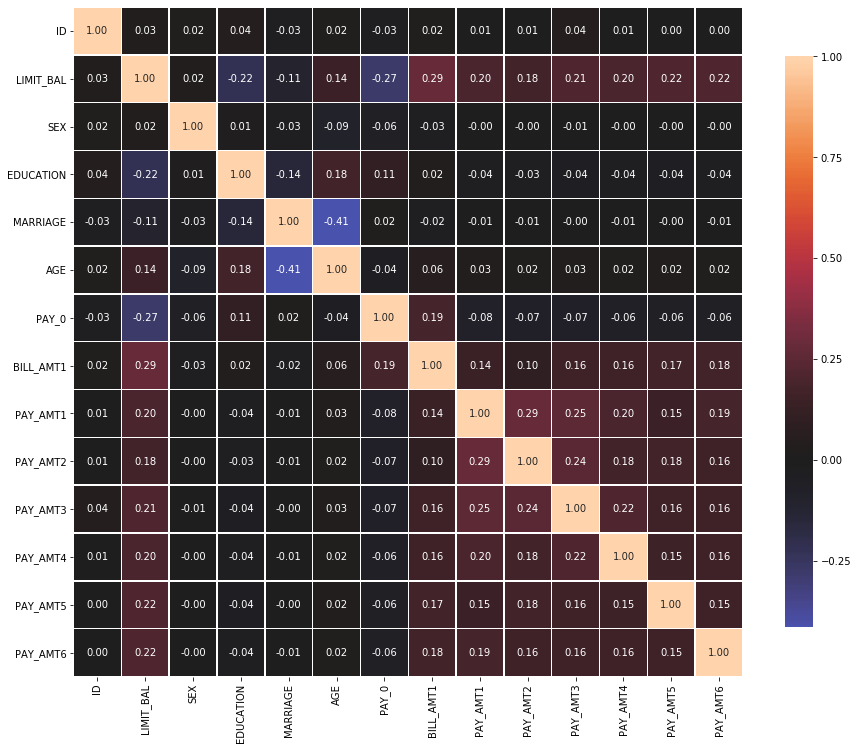

In [26]:
correlations = X.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

Now clean up the education and marriage columns as described earlier

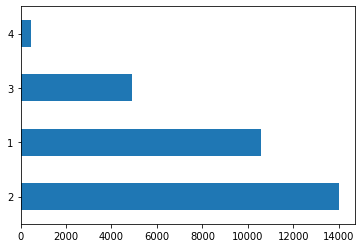

In [32]:
X.EDUCATION.replace([0,5,6],4,inplace=True)
X.EDUCATION.value_counts().plot(kind = "barh")

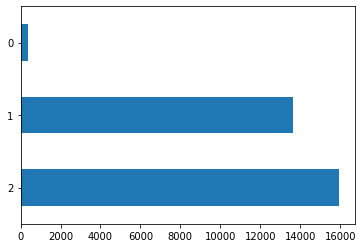

In [34]:
X.MARRIAGE.replace(3,0,inplace=True)
X.MARRIAGE.value_counts().plot(kind = "barh")

One-hot encode the categorical variables

In [40]:
X = pd.get_dummies(data=X, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0'])


# Machine Learning

First iteration where we just run ML regression models on the raw unpreprocessed data and compare results after

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [42]:
y_pred = clf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
rf_acc

0.814